## Аналитика в авиакомпании

«F9» — российская авиакомпания, выполняющая внутренние пассажирские авиаперевозки. Важно понять предпочтения пользователей, покупающих билеты на те или иные направления. В работе будет проанализирован спрос пассажиров на рейсы в различные города и на рейсы, выполняющиеся различными моделями самолетов.

#### Описание данных <a id='Описание'></a> 

В работе будут анализироваться результаты двух запросов. В первом содержится информация о:
- model — модели самолета
- flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года

Во втором запроме содержится информация о:
- city — городах
- average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года

#### Цель работы

Определить предпочтения пассажиров, покупающих билеты, относительно модели самолета и пункта назначения

#### План работы

1. [Общая информация](#Знакомство)
2. [Предобработка данных](#Предобработка)
3. [Исследование городов назначения](#Города)
4. [Исследвание моделей самолетов](#Модели)
5. [Обогащение данных](#Обогащение)
6. [Вывод](#Вывод)

#### Общая информация<a id='Знакомство'></a>

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.colors
import numpy as np


import requests # Импорт библиотеки для запросов к серверу
from bs4 import BeautifulSoup # Импорт библиотеки для автоматического парсинга странички
import re #Импорт библиотеки регулярных выражений 

In [2]:
#выведем первые строки датасетов и информацию о таблицах
models = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/query_1.csv')
cities = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/query_3.csv')

display(models.head())
display(models.info())
display(cities.head())
display(cities.info())

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


None

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


None

В результате SQL-запросов было получено 2 таблицы. В таблице modals указано 8 моделей самолетов и колличество рейсов, ими выполняемых. Пропусков нет, типы данных - object и int.
В таблице cities указаны города (в колличесве 101) и рейсы в них. Пропусков нет, типы данных - object и float.

В проекте используются небольшие таблицы, однако и их хранение можно оптимизировать: данные о среднем колличесве полетов  хранятся в типе `float64`,однако по факту можно использовать меньшее число байт для представления каждого значения. Используем подтип `float16` и на примере таблицы с городами посмотрим наколько компактнее стала таблица 

In [3]:
before_kb = cities['average_flights'].memory_usage(deep=True) 
print('Занято Кб изначально', before_kb)

Занято Кб изначально 936


In [4]:
cities['average_flights'] = cities['average_flights'].astype('float16')
after_kb= cities['average_flights'].memory_usage(deep=True) 
print('Занято Кб после преобразований:', after_kb)

Занято Кб после преобразований: 330


Таким образом, мы почти в треть уменьшили объем занимаемой памяти. Конечно, в данный момент мы говорим о килобайтах и на этой конретной таблице такая экономия не сиьно скажется, однако это может быть актуально, если таблица будет существенно больше. 

#### Предобработка данных <a id='Предобработка'></a> 

Типы данных указаны корректно, однако для наглядности столбец со средним колличевом рейсов можно округлить до десятых 

In [5]:
cities['average_flights'] = round(cities['average_flights'], 1)
cities.sample(5)

,city,average_flights
64,Петрозаводск,5.898438
70,Санкт-Петербург,31.203125
4,Астрахань,2.500000
67,Ростов-на-Дону,10.203125
74,Сочи,9.601562


Проверим наличие дубликатов:

In [6]:
#невооруженным взглядом видно, что в таблице models дубликатов нет, так что проверим cities 
print("Колличество дубликатов в таблице cities:", cities.duplicated().sum())

Колличество дубликатов в таблице cities: 0


Также, так как таблица cities сравнительно небольшая мы можем зрительно проверить названия городов на предмет неправильного регистра или разного написания. 

In [7]:
cities['city'].unique()

array(['Абакан', 'Анадырь', 'Анапа', 'Архангельск', 'Астрахань',
       'Барнаул', 'Белгород', 'Белоярский', 'Благовещенск', 'Братск',
       'Брянск', 'Бугульма', 'Владивосток', 'Владикавказ', 'Волгоград',
       'Воркута', 'Воронеж', 'Геленджик', 'Горно-Алтайск', 'Грозный',
       'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Йошкар-Ола',
       'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Когалым',
       'Комсомольск-на-Амуре', 'Краснодар', 'Красноярск', 'Курган',
       'Курск', 'Кызыл', 'Липецк', 'Магадан', 'Магнитогорск', 'Махачкала',
       'Минеральные Воды', 'Мирный', 'Москва', 'Мурманск', 'Надым',
       'Нальчик', 'Нарьян-Мар', 'Нерюнгри', 'Нефтеюганск',
       'Нижневартовск', 'Нижнекамск', 'Нижний Новгород', 'Новокузнецк',
       'Новосибирск', 'Новый Уренгой', 'Норильск', 'Ноябрьск', 'Нягань',
       'Омск', 'Оренбург', 'Орск', 'Пенза', 'Пермь', 'Петрозаводск',
       'Петропавловск-Камчатский', 'Псков', 'Ростов-на-Дону', 'Салехард',
       'Самара', 'Санк

Посмотрим также, как в целом распределены данные 

In [8]:
display(cities.describe().T)
print('медиана:', cities.median())


,count,mean,std,min,25%,50%,75%,max
average_flights,101.0,5.496094,13.117188,1.0,2.0,3.0,5.898438,129.75


медиана: average_flights    3.0
dtype: float64


Таблица с городам содержит явный выброс, так как 75% данных лежат в границах примерно 6 полетов в день, к тому же стандартное отклонение значительно больше самого среднего. Также медиана в половину меньше среднего, а значит, что если мы не будем брать в расчет город с самым большим колличесвом прилетов(как можно догадаться, это Москва), то в среднем города по России принимаю по 3 рейса в день 

#### Города <a id='Города'></a> 

Построим график, который показывает колличесво рейсов в зависимости от города. Так как в таблице около 100 городов, первый график лишь рисует общую картину распределения рейсов - в нем не подписаны города, однако очевидо, что есть несколько небольших пиков (это будут топ-10 городов) и один из них, просто невероятно огромный - это Москва. С помощью этого графика можно наглядно оценить насколько больше рейсов прибывает в среднем за день в Москву, чем в другие грода России - в среденем каждый 4ый рейс в день прибывает в Москву

In [9]:
print('Процентное соотношение рейсов в Москву ко всем остальным городам: {:.0%}'.format(
            cities['average_flights'][43] / sum(cities['average_flights'])))

Процентное соотношение рейсов в Москву ко всем остальным городам: 23%


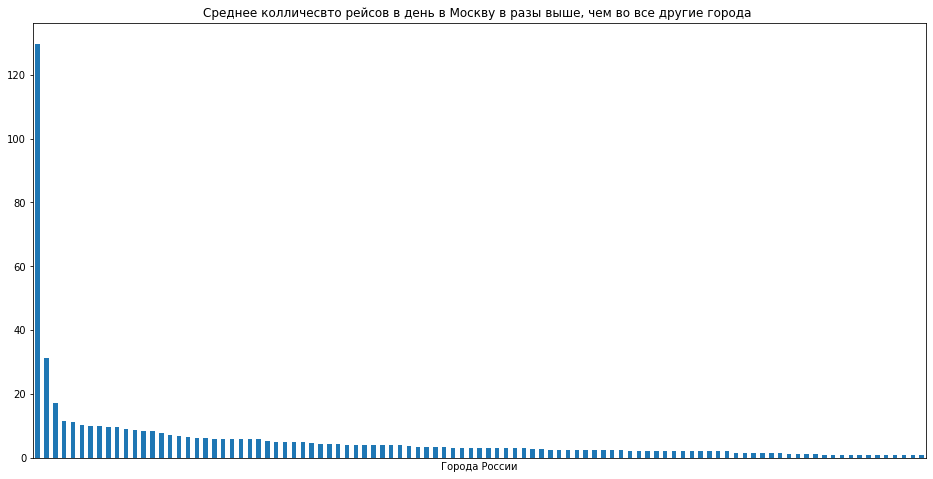

In [10]:
ax = cities.sort_values(by='average_flights', ascending = False)
ax.plot(kind='bar',figsize=(16,8), legend=False).axes.get_xaxis().set_ticks([])
plt.xlabel("Города России")
plt.title('Среднее колличесвто рейсов в день в Москву в разы выше, чем во все другие города ')
plt.show()

Рассмотрим 10 самых популярных породов за август 2018

In [11]:
top10 = cities.sort_values(by='average_flights', ascending = False).head(10)
top10

,city,average_flights
43,Москва,129.750000
70,Санкт-Петербург,31.203125
54,Новосибирск,17.296875
33,Красноярск,11.601562
20,Екатеринбург,11.296875
67,Ростов-на-Дону,10.203125
63,Пермь,10.101562
10,Брянск,10.000000
74,Сочи,9.601562
84,Ульяновск,9.601562


Text(0.5, 1.0, 'Среднее колличесвто рейсов по самым популярным городам')

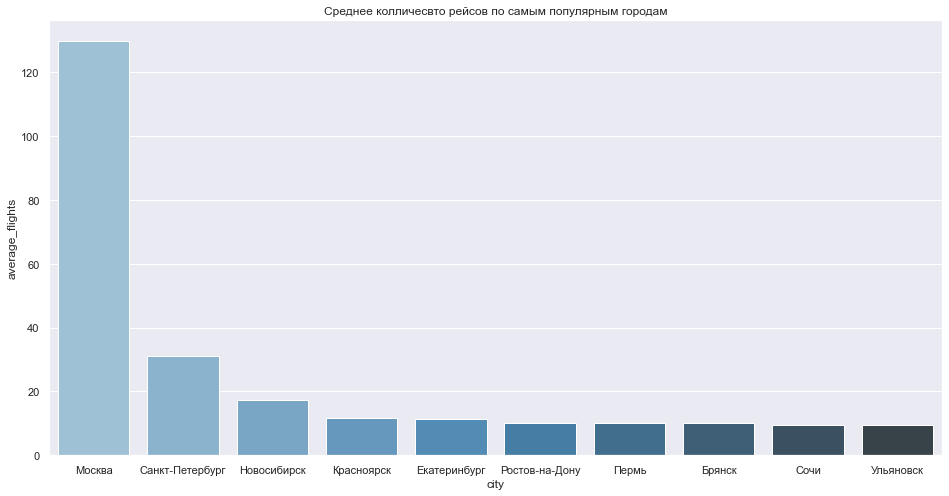

In [12]:
sns.set(rc={'figure.figsize':(16,8)})
sns.barplot(x='city', y='average_flights', data=top10, palette="Blues_d")
plt.title('Среднее колличесвто рейсов по самым популярным городам')

Для анализа использовался август и, несмотря на то, что это сезон отпусков, Москва абсолютный лидер по количеству прибывающих рейсов в день (притом южные города - Сочи или Ростов-на-Дону располагаются ближе к концу десятки). На втором месте Санкт-Петербург - здесь значительно меньше ресйсов, чем в Москве, но ощутимо больше, чем во всех остальных. На третьем месте - Новосибирск. 

Такая ситуация может быть связана с тем, что Москва - это самый мощный хаб и даже если пассажиры хотят попасть в какие-то другие города, они вынуждены лететь через Москву (например, иногда пассажиры могут лететь из Сибири на Урал - с пересадкой в столице). Тот факт, что большинсвто из указанных городов имеет международные аэропорты в реальной жизни не влияет на ситуацию.

Можно предположить, что такая ситуация возникает из-за того, что гражданская авиация не субсидируется государством (например, так как это было в СССР) и авиакомпании должны сами покрывать все убытки, которые неизбежно возникают там, где нет стабильного пассажиропотока. Например, аэропорт, который обслуживает, один-два рейса в сутки, все равно должен иметь персонал, технических специалистов, охрану и т.д. Все это должно финансироваться средствами авиакомпании, которая туда летает, и чтобы ей было выгодно эти затраты будут вкладываться в стоимость билетов. Поэтому кстати, неудивительно, что самые низкие аэрпортовые сборы в Москве - через столичные аэропорты проходят миллионы пассажров и затраты делятся на всех. Таким образом, для пассажиров выгоднее летать туда, куда летает большинство. 

Добавим в таблицу с 10 городами население этих городов на 2018 год. Данные взяты [отсюда]( 
https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9)


#### Модели самолетов <a id='Модели'></a> 

In [13]:
population = [12506, 5352, 1613, 1091, 1469, 1130, 1052, 406, 424, 627]
top10['population'] = population
top10

,city,average_flights,population
43,Москва,129.750000,12506
70,Санкт-Петербург,31.203125,5352
54,Новосибирск,17.296875,1613
33,Красноярск,11.601562,1091
20,Екатеринбург,11.296875,1469
67,Ростов-на-Дону,10.203125,1130
63,Пермь,10.101562,1052
10,Брянск,10.000000,406
74,Сочи,9.601562,424
84,Ульяновск,9.601562,627


In [14]:
top10.corr()

,average_flights,population
average_flights,1.000000,0.976177
population,0.976177,1.000000


Рассмотрим колличесвто рейсов на разные модели самолетов

Text(0.5, 1.0, 'Колличесвто рейсов по моделям самолетов')

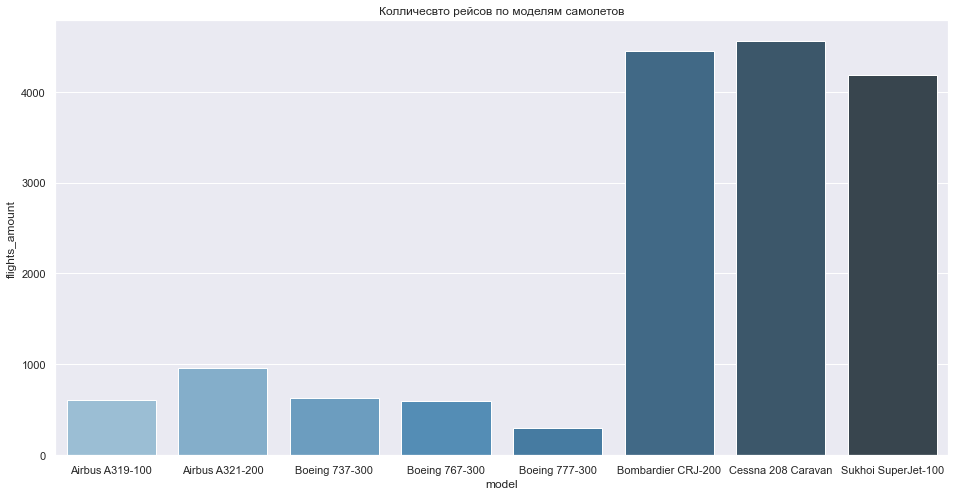

In [15]:
sns.set(rc={'figure.figsize':(16,8)})
sns.barplot(x='model', y='flights_amount', data=models, palette="Blues_d")
plt.title('Колличесвто рейсов по моделям самолетов')

Видно, что аэробус и боинг представлены нескольким моделями:  модель Airobus A321 популярнее А319, а Boeing 777 менее популярен, чем две другие модели.

Объеденим данные по производителям и посмотрим на компании, производящие самолеты

In [16]:
models['company'] = models['model'].apply(lambda x: (x.split(' '))[0])
models_pivot = models.pivot_table(index=['company'], values = ['flights_amount'], aggfunc = 'sum')
models_pivot

,flights_amount
company,
Airbus,1567
Boeing,1530
Bombardier,4446
Cessna,4557
Sukhoi,4185


Text(0.5, 1.0, 'Распределение рейсов по производителям самолетов')

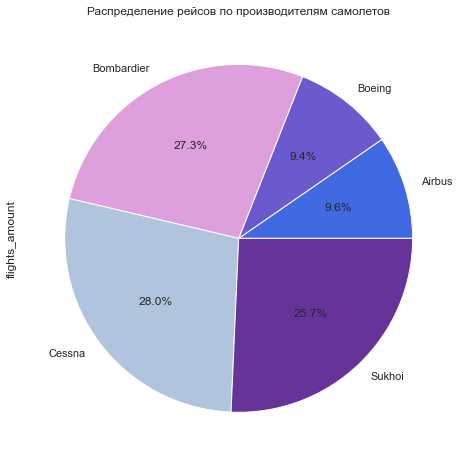

In [17]:
colors = [ 'royalblue', 'slateblue', 'plum','lightsteelblue', 'rebeccapurple']
models_pivot.plot(kind='pie', subplots=True,figsize=(12,8), legend = False, autopct='%1.1f%%', colors=colors)
plt.title('Распределение рейсов по производителям самолетов')

Наиболее известные американская компания Боинг и европейская Аэробус представляют в наших данных примерно равные, но небольшие части - примерно по одной десятой на каждую компанию за сентябрь 2018 года. Остальные компании соавляют примерно равные доли с небольшим лидерсвтом Цесны. Отечественное авиастоение, представленное моделью Сухой Суперджет, округленно берет на себя каждый четвертый рейс (так как данные за 2018 год катастрофа мая 2019 с этой моделью никак не влияет). На 2018 год доля самолетов долья самолетов канадской компании Бомбардье довольно высока, однако в 2018 году это компания находится в кризисе, частично из-за пошлин введенных США, поэтому в будущем её доля скорее будет уменьшаться и возможно часть их модель CRJ-2000 будет замещаться моделями Сухой Суперждет. 
Любопытно, что самую большую долю среди всех моделей занимает Цессна 208 Караван - малый однодвигательный самолет с пассажировместимостью до 14 человек, то есть это модель качетвенно другая по отношению ко всем вышеперечисленным. Несмотря на то, что он небольшой его сферы применения выше - это и экскурсионные полеты, и перевозка VIP-пассажиров, и спасательные работы.К тому же, они заправляется обычным авиационным керосином, а не авиционным бензином, что тоже влиет на цены билетов. 

#### Обогащение данных

Обогатим данные, добавив информацию о максимальном колличесве пассажиров. 
Информация частично взята с [сайта](https://www.airlines-inform.ru/commercial-aircraft/)

In [18]:
vals = [156, 220, 149, 328, 550, 50, 14, 98] #так как таблица маленькая здесь я добавила даннные вручную 
models['capacity'] = vals
models

,model,flights_amount,company,capacity
0,Airbus A319-100,607,Airbus,156
1,Airbus A321-200,960,Airbus,220
2,Boeing 737-300,630,Boeing,149
3,Boeing 767-300,600,Boeing,328
4,Boeing 777-300,300,Boeing,550
5,Bombardier CRJ-200,4446,Bombardier,50
6,Cessna 208 Caravan,4557,Cessna,14
7,Sukhoi SuperJet-100,4185,Sukhoi,98


Теперь в таблице приведена максимальная вмесимость пассажиров. Предположим, что самолеты всегла летают полными или почти полными и посмотрим на корреляцию между колличеством рейсов и вместимостью самолета

In [19]:
models.corr()

,flights_amount,capacity
flights_amount,1.000000,-0.723209
capacity,-0.723209,1.000000


Обнаружилась довольно сильная обратная корреляция между колличеством рейсов и вместимостью пассажиров. А имеенно, чем меньше самолет, тем чаще он летает - это логичая ситуация для такого распределения городов как в России. У нас один огромный город, несколько довольно больших городов и много маленьких, таким образом можно предположить, что боинг 777 в основном курсирует между Москвой и крупными городами, а во всех остальных городах летают самлеты поменьше

Посмотрим на пассажиропоток, умножив вместимость самолета на коллиичесво рейсов

In [20]:
models['traffic'] = models['flights_amount'] * models['capacity']
models.sort_values(by = 'traffic', ascending=0)

,model,flights_amount,company,capacity,traffic
7,Sukhoi SuperJet-100,4185,Sukhoi,98,410130
5,Bombardier CRJ-200,4446,Bombardier,50,222300
1,Airbus A321-200,960,Airbus,220,211200
3,Boeing 767-300,600,Boeing,328,196800
4,Boeing 777-300,300,Boeing,550,165000
0,Airbus A319-100,607,Airbus,156,94692
2,Boeing 737-300,630,Boeing,149,93870
6,Cessna 208 Caravan,4557,Cessna,14,63798


Если предположить, что все самолеты летают с полной загрузкой, то несомненый лидер по перевозкам - это Сухой суперджет. Также любопытно, что Аэробус 321 и Боинг 767, которые занимают довольно скромную долю в общих рейсах по пассажиропотоку вполне сравнимы с почти лидером Бомбардье. Данные по пассажиропотоку актуальнее для пассажиров, таким образом получается, что чаще всего пассажиры F9 летаю на суперджете, однако вероятность попасть на бомбардье или Аэробус тоже довольно велика. Соотвесенно, Цессна, которая занимала лидирующие позиции по колличесву рейсов засчет очень малой вместимость остается довольно редким средсвом передвижения для пассажиров  

Внесем дополнительные данные и в таблицу с городами, а именно население городов. Для этого воспользуемся данными из [Википедии](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9)

In [21]:
URL='https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9'
req = requests.get(URL) # GET-запрос
soup = BeautifulSoup(req.text,  "html.parser")
#soup = BeautifulSoup(req.text, 'lxml')


In [22]:
content = []
for row in soup.find_all('tr'):
    row_values = [] # сохраняем все значения из строки
    for col in row.find_all('td'):
        row_values.append(col.text)
    content.append(row_values) # складываем строку в финальный массив данных
#print(content)

In [23]:
headings = []
for row in soup.find_all('th'):
    headings.append(row.text)
print(headings)

['№', 'Город', 'Население, тыс. человек\n', '', 'в1897[17]', '1897', '1926', '1939', '1959', '1970', '1979', '1989', '2002', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021\n', '\n', 'Субъект РФ\n', 'Кол-вогородов\n', 'Города с населением более 100 тыс. человек\n', 'Города России', 'Россия в темах', 'История', 'Хронология', 'По темам', 'Государственный строй', 'География', 'Экономика', 'Вооружённые силы', 'Население', 'Культура', 'Спорт']


Есть содержании таблицы и заголовки, но из-за особенностей таблицы они пока не складываются в датафрейм, поэтому вручную отрежем все лишнее - посмотрим под какими иднексами последний столбец и последняя строка, все остальное уберем 

In [24]:
headings.index('2021\n')

24

In [25]:
#content.index(['173\n', '', 'Зеленодольск', '—', '—', '30', '60', '77', '85',
#    '94', '100', '98', '98', '98', '98', '98', '98', '99', '99', '99', '100', '100', '\n'])

In [26]:
content1 = content[:173]
headings1 = headings[:23]

In [27]:
popul = pd.DataFrame(content1, columns=headings1)
popul.head()


,№,Город,"Население, тыс. человек\n",,в1897[17],1897,1926,1939,1959,1970,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,1\n,2,Москва[18],1039,2080,4609,6133,7194,8057,8878,...,11613,11980,12108,12198,12330,12381,12506,12615,12678,12655\n
3,2\n,1,Санкт-Петербург,1265,1737,3431,3390,4033,4569,4989,...,4953,5028,5132,5192,5226,5282,5352,5384,5398,5384\n
4,3\n,,Новосибирск,8,120,404,885,1161,1309,1420,...,1499,1524,1548,1567,1584,1603,1613,1618,1626,1620\n


Дата-фрейм получился, но из-за особенностей таблицы, строки поползли - первые две строки с пропусками мы просто удалим и сверимся с исходной таблицей: данные, которые нам нужны за 2018 год попали в колонку 2016. Так как эта таблица целиком нас мало интересует просто отрежем все лишнее и переименуем столбцы

In [28]:
popul_good = popul.loc[:,["Население, тыс. человек\n", '2016']].dropna()
popul_good.columns = ['city', '2018'] 
popul_good.head(10)

,city,2018
2,Москва[18],12506
3,Санкт-Петербург,5352
4,Новосибирск,1613
5,Екатеринбург,1469
6,Казань,1244
7,Нижний Новгород,1259
8,Челябинск,1202
9,Самара,1163
10,Омск,1172
11,Ростов-на-Дону,1130


Теперь мы получили данные, которыенам нужны, но их нужно немного обработать - убрать цифры (и кое-где иностранные буквы) из названий и певести колличесвто тысяч людей в целочисленный тип 

In [29]:
popul_good['city'] = popul_good['city'].apply(lambda x: ''.join(re.findall('[А-я]', x)))
popul_good['2018'] = popul_good['2018'].apply(lambda x: int(x))
popul_good

,city,2018
2,Москва,12506
3,СанктПетербург,5352
4,Новосибирск,1613
5,Екатеринбург,1469
6,Казань,1244
...,...,...
168,ХантыМансийск,98
169,Ногинск,103
170,Елец,104
171,Железногорск,101


Теперь объеденим нашу исходную таблицу с таблицей с населением по столбцу с названием грода

In [30]:
cities_enriched = cities.merge(popul_good, on='city', how='left')
display(cities_enriched)
cities_enriched.info()

,city,average_flights,2018
0,Абакан,3.900391,184.0
1,Анадырь,1.000000,NaN
2,Анапа,2.199219,NaN
3,Архангельск,5.398438,350.0
4,Астрахань,2.500000,534.0
...,...,...,...
96,Чита,1.599609,349.0
97,Элиста,4.898438,103.0
98,Южно-Сахалинск,4.300781,NaN
99,Якутск,2.699219,312.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float16
 2   2018             67 non-null     float64
dtypes: float16(1), float64(1), object(1)
memory usage: 2.6+ KB


В таблице оказалось довольно много пропусков, так как данные о населении у нас были изначально по городам больше 100 населения, а аэропорты могут быть и в более маленьких городах. Но для того, чтобы увидеть есть корреляция или нет, нам хватит и 67 

In [31]:
cities_enriched.corr()

,average_flights,2018
average_flights,1.00000,0.98006
2018,0.98006,1.00000


Получилась прямая зависимость между населением города и колличесвом рейсов туда. То есть в большие города часта летаютсамолеты, а в маленькие реже. Это подтверждает утрверждение выдвинутое в блоке про исследование городов - туда, где много людей живет, часто летают и наоборот: в маленьком городе не так много людей вообще, поэтому потенциальных пассажиров тоже в разы меньше. 

#### Вывод <a id='Вывод'></a>

В работе были проанализирваны резултаты двух запросов - о городах, куда летают самолеты F9 и о моделях этой компании. Москва несомненный лидер по среднему колличесву прибывающих рейсов в день - почти каждый четвертый самолет кажды день прилетает в Москву. Что касается моделей, по данным на сентябрь 2018 года - большинтсво рейсов за крошечным однодвигательным самолетом Цессна 208 Караван, хотя по пассажиропотоку лидерсво за Сухим Суперджетом